# Representation Learning & Generative Learning using Autoencoders & GANs

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called *latent representations* or *codings*, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making encoders useful for dimensionality reduction, especially for visualisation purposes. Autoencoders also act as feature detectors & they can be used for unsupervised pretraining of deep neural networks. Lastly, some autoencoders are *generative models*: they are capable of randomly generating new data that looks very similar to the training data. For example, you could train an autoencoder on pictures of faces, & it would then be able to generate new faces. However, the generated images are usually fuzzy & not entirely realistic.

In contrast, faces generated by generative adversarial networks (GANs) are now so convincing that it is hard to believe that the people they represent do not exist. You can judge for yourself by visiting *https://thispersondoesnotexist.com/*, a website that shows faces generated by a recent GAN architecture called *StyleGAN* (you can also check out *https://thisrentaldoesnotexist.com/* to see some generated Airbnb bedrooms). GANS are now widely used for super resolution (increasing the resolution of an image), colourisation, powerful image editing (e.g., replacing photo bombers with realistic backgrounds), turning a simple sketch into a photorealistic image, predicting the next frames in a video, augmenting a dataset (to train other models), generating other types of data (such as text, audio, & time series), identifying the weaknesses in other model & strengthening them, & more.

Autoencoders & GANs are both unsupervised, they both learn dense representations, they can both be used as generative models, & they have many similar applications. However, they work very differently:

* Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult. For example, you can limit the size of the latent representations, or you can add noise to the inputs & train the network to recover the original inputs. These constraints prevent the autoencoder from trivially copying the inputs directly to the outputs, which forces it to learn efficient ways of representing the data. In short, the codings are byproducts of the autoencoder learning the identity function under some constraints.
* GANs are composed of two neural networks: a *generator* that tries to generate data that looks similar to the training data, & a *discriminator* that tries to tell real data from fake data. This architecture is very original in deep learning in that the generator & the discriminator compete against each other during training: the generator is often compared to a criminal trying to make realistic counterfeit money, while the discriminator is like the police investigator trying to tell real money from fake. *Adversarial training* (training competing neural networks) is widely considered as one of the most important ideas in recent years. In 2016, Yann LeCun even said that it was "the most interesting idea in the last 10 years in machine learning".

In this lesson, we will start by exploring in more depth how autoencoders work & how to use them for dimensionality reduction, feature extraction, unsupervised pretraining, or as generative models. This will naturally lead us to GANs. We'll build a simple GAN to generate fake image, but we will see that training is often quite difficult. We will discuss the main difficulties you will encounter with adversarial training, as well as some of the main technique to work around these difficulties. Let's start with autoencoders!

---

# Efficient Data Representations

Which of the following number seqeunces do you find the easiest to memorise?

* 40, 27, 25, 36, 81, 57, 10, 3, 19, 63
* 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14

At first glance, you might think that the first sequence should be easier, since it is much shorter. However, if you look carefully at the second sequence, you will notice that it is just the list of even numbers from 50 down to 14. Once you notice this pattern the second sequence becomes much easier to memorise than the first, because you only need to remember the pattern (i.e., decreasing even numbers) & the starting & ending numbers (i.e., 50 & 14). Note that if you could quickly & easily memorise very long sequences, you would not care much about the existence of a pattern in the second sequence. You would just learn every number by heart, & that would be that. The fact that it is hard to memorise long sequences is what makes it useful to recognise patterns, & hopefully this clarifies why constraining an autoencoder during training pushes it to discover & exploid patterns in the data.

The relationship between memory, perception, & pattern matching was famously studied by William Chase & Herbert Simon in the early 1970s. They observed that expert chess players were able to memorise the positions of all the pieces in a game by looking at the board for just 5 seconds, a task that most people would find impossible. However, this was only the case when the pieces were placed in realistic positions (from actual games), not when the pieces were placed randomly. Chess experts don't have a much better memory than you & I; they just see chess patterns more easily, thanks to their experience with the game. Noticing patterns helps them store information efficiently.

Just like the chess players in this memory experiment, an autoencoder looks at the inputs, converts them to an efficient latent representation, & then spits out something that (hopefully) looks very close to the inputs. An autoencoder is always composed of two parts: an *encoder* (or *recognition network*) that converts the inputs to a latent representation, followed by a *decoder* (or *generative network*) that converts the internal representation to the outputs.

<img src = "Images/Chess Memory Experiment & Simple Autoencoder.png" width = "600" style = "margin:auto"/>

As you can see, an autoencoder typically has the same architecture as a multi-layer perceptron (MLP), except that the number of neurons in the output layer must be equal to the number of inputs. In this example, there is just one hidden layer composed of two neurons (the encoder), & one output layer composed of three neurons (the decoder). The outputs are often called the *reconstructions* because the autoencoder tries to reconstruct the inputs, & the cost function contains a *reconstruction loss* that penalises the model when the reconstructions are different from the inputs.

Because the internal representation has a lower dimensionality than the input data (it is 2D instead of 3D), the autoencoder is said to be *undercomplete*. An undercomplete autoencoder cannot trivially copy its inputs to the codings, yet it must find a way to output a copy of its inputs. It is forced to learn the most important features in the input data (& drop the unimportant ones).

Let's see how to implement a very simple undercomplete autoencoder for dimensionality reduction.

---

# Performing PCA with an Undercomplete Linear Autoencoder

If the autoencoder uses only linear activations & the cost function is the mean squared error (MSE), then it ends up performing principal component analysis (PCA).

The following code builds a simple linear autoencoder to perform PCA on a 3D dataset, projecting it to 2D:

In [2]:
from tensorflow import keras

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape = [3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape = [2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss = "mse", optimizer = keras.optimizers.SGD(learning_rate = 0.1))

This code is really not every different from all the MLPs we built in past chapters,but there are a few things to note:

* We organised the autoencoder into two subcomponents: the encoder & the decoder. Both are regular `Sequential` models with a single `Dense` layer each, & the autoencoder is a `Sequential` model containing the encoder followed by the decoder (remember that a model can be used as a layer in another model).
* The autoencoder's number of outputs is equal to the number of inputs (i.e., 3).
* To perform simple PCA, we do not use any activation function (i.e., all neurons are linear), & the cost function is the MSE.

Now, let's train the model on a simple 3D dataset & use it to encode that same dataset (i.e., to project it to 2D):

In [3]:
import numpy as np

def generate_3d_data(m, w1 = 0.1, w2 = 0.3, noise = 0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis = 0, keepdims = 0)
history = autoencoder.fit(X_train, X_train, epochs = 20)
codings = encoder.predict(X_train)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8767  
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5519 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3840 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3224 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2722 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2487 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2166 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2042 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1876 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1645 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1569 
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1460 
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1218 
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1128 
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0995 
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━

Note that the same dataset, `X_train` is used as both the inputs & the targets. The below figure shows the original 3D dataset (on the left) & the output of the autoencoder's hidden layer (i.e., the coding layer, on the right). As you can see, the autoencoder found the best 2D plane to project the data onto, preserving as much variance in the data as it could (just like PCA).

<img src = "Images/PCA Performed by Undercomplete Linear Autoencoder.png" width = "600" style = "margin:auto"/>

---

# Stacked Autoencoders

Just like other neural networks we have discussed, autoencoders can have multiple hidden layers. In this case, they are called *stacked autoencoders* (or *deep autoencoders*). Adding more layers helps the autoencoder learn more complex codings. That said, one must be careful not to make the autoencoder too powerful. Imagine an encoder so powerful that it just learns to map each input to a single arbitrary number (& the decoder learns the reverse mapping). Obviously, such an autoencoder will reconstruct the training data perfectly, but it will not have learned any useful data representation in the process (& it is unlikely to generalise well to new instances).

The architecture of a stacked autoencoder is typically symmetrical with regard to the central hidden layer (the coding layer). To put it simply, it looks like a sandwich. For example, an autoencoder for MNIST may have 784 inputs, followed by a hidden layer of 100 neurons, then a central hidden layer of 30 neurons, then another hidden layer with 100 neurons, & an output layer with 184 neurons. 

<img src = "Images/Stacked Autoencoder.png" width = "500" style = "margin:auto"/>

## Implementing a Stacked Autoencoder Using Keras

You can implement a stacked autoencoder very much like a regular deep MLP. In particular, the same techniques we used before for training deep nets can be applied. For example, the following code builds a stacked autoencoder for fashion MNIST (loaded & normalised), using the SELU activation function.

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
X_train, X_val = X_train[:-5000], X_train[-5000:]
y_train, y_val = y_train[:-5000], y_train[-5000:]

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(30, activation = "selu")
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = "selu", input_shape = [30]),
    keras.layers.Dense(784, activation = "sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_autoencoder = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_autoencoder.compile(loss = "binary_crossentropy", 
                            optimizer = keras.optimizers.SGD(learning_rate = 1.5))
stacked_autoencoder.fit(X_train, X_train, epochs = 10,
                        validation_data = (X_val, X_val))

/Users/jiehengyu/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3828 - val_loss: 0.3139
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3075 - val_loss: 0.3024
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2996 - val_loss: 0.2990
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2950 - val_loss: 0.2939
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2927 - val_loss: 0.3013
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2898 - val_loss: 0.2909
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2891 - val_loss: 0.2886
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2873 - val_loss: 0.2884
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2865 - val_loss: 0.2870
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2861 - val_loss: 0.2861


Let's go through the code:

* Just like earlier, we split the autoencoder model into two submodels: the encoder & the decoder.
* The encoder takes 28 x 28-pixel grayscale images, flattens them sot aht each image represents a vector of size 784, then processes these vectors through two `Dense` layers of diminishing sizes (100 units then 30 units), both using the SELU activation function (you may want to add LeCun normal initialization as well, but the network is not very deep, so it won't make a big difference). For each input image, the encoder outputs a vector of size 30.
* The decoder takes codings of size 30 (output by the encoder) & preprocesses them through two `Dense` layers of increasing sizes (100 units then 784 units) & it reshapes the final vectors into 28 x 28 arrays so the decoder's outputs have the same shape as the encoder's inputs.
* While compiling the stacked autoencoder, we use the binary cross-entropy loss instead of the mean squared error. We are treating the reconstruction task as a multilabel binary classification problem: each pixel intensity represents the probability that the pixel should be black. Framing it this way (rather than a regression probelm) tends to make the model converge faster.
* Finally, we train the model using `X_train` as both the inputs & targets (and similarly, we use `X_val` as both the validation inputs & targets).

## Visualising the Reconstructions

One way to ensure that an autoencoder is properly trained is to compare the inputs & the outputs: the differences should not be too significant. Let's plot a few images from the validation set, as well as their reconstructions:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


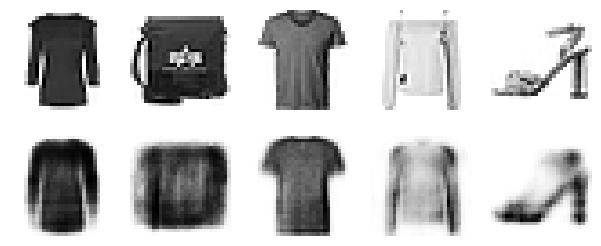

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_image(image):
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

def show_reconstructions(model, n_images = 5):
    reconstructions = model.predict(X_val[:n_images])
    fig = plt.figure(figsize = (n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_val[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_autoencoder)

The reconstructions are recognisable, but a bit too lossy. We may need to train the model for longer, or make the encoder & decoder deeper, or make the codings larger. But if we make the network too powerful, it will manage to make perfect reconstructions without having learned any useful patterns in the data. For now, let's go with this model.

## Visualizing the Fashion MNIST Dataset

Now that we have trained a stacked autoencoder, we can use it to reduce the dataset's dimensionality. For visualisation, this does not give great results compared to other dimensionality reduction algorithms, but one big advantage of autoencoders is that they can handle large datasets, with many instances & many features. So on strategy is to use an autoencoder to reduce the dimensionality down to a reasoable level, then use another dimensionality reduction algorithm for visualisation. Let's use this strategy to visualise fashion MNIST. First, we use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we use scikit-learn's implementation of the t-SNE algorithm to reduce the dimensionality down to 2 for visualisation:

In [6]:
from sklearn.manifold import TSNE

X_val_compressed = stacked_encoder.predict(X_val)
tsne = TSNE()
X_val_2D = tsne.fit_transform(X_val_compressed)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Now, we can plot the dataset:

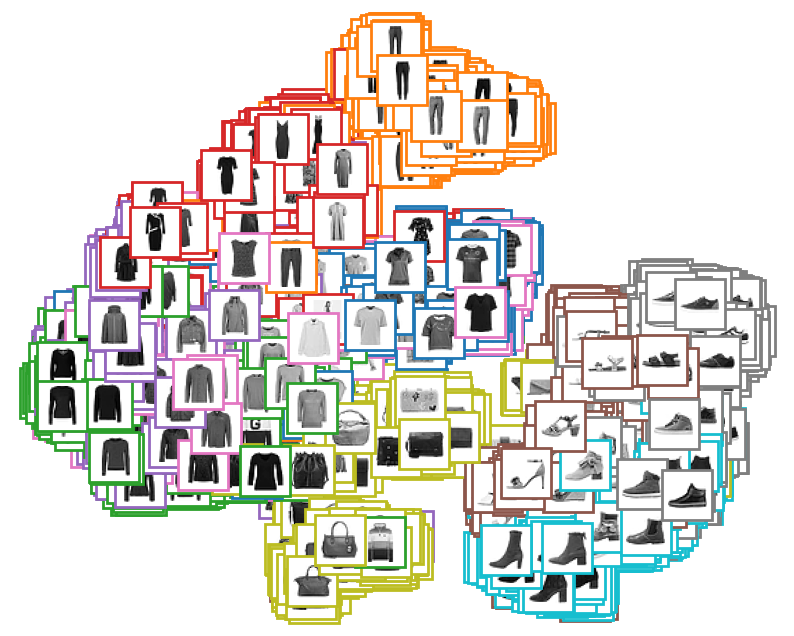

In [7]:
%matplotlib inline
import matplotlib as mpl

plt.figure(figsize = (10, 8))
cmap = plt.cm.tab10
plt.scatter(X_val_2D[:, 0], X_val_2D[:, 1], c = y_val, s = 10, cmap = cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_val_2D):
    dist = np.sum((position - image_positions) ** 2, axis = 1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_val[index], cmap = "binary"),
            position, bboxprops = {"edgecolor": cmap(y_val[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

The t-SNE algorithm identified several clusters which match the classes reasoably well (each class is represented with a different colour).

So, autoencoders can be used for dimensionality reduction. Another application is for unsupervised pretraining.

## Unsupervised Pretraining using Stacked Autoencoders

If you are tackling a complex supervised task but do not ahve a lot of labeled training data, one solution is to find a neural network that performs a similar task & reuse its lower layers. This makes it possible to train a high-performance model using little training data because your neural network won't have to learn all the low-level features; it will just reuse the feature detectors learned by the existing network.

Similarly, if you have a large dataset but most of it is unlabeled, you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for your actual task & train it using the labeled data. For example, the below figure shows how to use a stacked autoencoder to perform unsupervised pretraining for a classification neural network. When training the classifier, if you really don't have much labeled training data, you may want to freeze the pretrained layers (at least the lower ones).

<img src = "Images/Unsupervised Pretraining using Autoencoders.png" width = "500" style = "margin:auto"/>

There is nothing special about the implementation: just train an autoencoder using all the training data (labeled plus unlabeled), then reuse its encoder layers to create a new neural network.

Next, let's look at a few techniques for training stacked autoencoders.

## Tying Weights

When an autoencoder is neatly symmetrical, like the one we just built, a common technique is to *tie* the weights of the decoder layers to the weights of the encoder layers. This halves the number of weights in the model, speeding up training & limiting the risk of overfitting. Specifically, if the autoencoder has a total of *N* layers (not counting the input layer), & $W_L$ represents the connection weights of the $L^{th}$ layer (e.g., layer 1 is the first hidden layer, layer *N*/2 is the coding layer, & layer N is the output layer), then the decoder layer weights can be defined simply as: $W_{N - L + 1} = W^{\intercal}_L$ (with $L = 1, 2, ..., N/2$).

To tie weights between layers using keras, let's define a custom layer:

In [8]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation = None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name = "bias", initializer = "zeros",
                                      shape = [self.dense.input_shape[-1]])
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b = True)
        return self.activation(z + self.biases)

This custom layer acts like a regular `Dense` layer, but it uses another `Dense` layer's weights, transposed (setting `transpose_b = True` is equivalent to transposing the second argument, but it's more efficient as it performs the transposition on the fly within the `matmul()` operation). However, it uses its own bias vector. Next, we can build a new stacked autoencoder, much like the previous one, but with the decoder's `Dense` layers tied to the encoder's `Dense` layers:

In [9]:
dense_1 = keras.layers.Dense(100, activation = "selu")
dense_2 = keras.layers.Dense(30, activation = "selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    dense_1,
    dense_2
])
tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation = "selu"),
    DenseTranspose(dense_1, activation = "sigmoid"),
    keras.layers.Reshape([28, 28])
])

#tied_autoencoder = keras.models.Sequential([tied_encoder, tied_decoder])

/Users/jiehengyu/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


This model achieves a very slightly lower reconstruction error than the previous model, with almost half the number of parameters.

## Training One Autoencoder at a Time

Rather than training the whole stacked autoencoder in one go just like we just did, it is possible to train one shallow autoencoder at a time, then stack all of them into a single tacked autoencoder (hence the name), as shown below. This technique is not used much nowadays, but you may still trun into papers that talk about "greedy layerwise training", so it's good to know what it means.

<img src = "Images/Training One Autoencoder at a Time.png" width = "600" style = "margin:auto"/>

During the first phase of training, the first autoencoder learns to reconstruct the inputs. Then we encode the whole training set using this first autoencoder, & this gives us a new (compressed) training set. We then train a second autoencoder on this new dataset. This is the second phase of training. Finally, we build a big sandwich using all these autoencoders (i.e., we first stack the hidden layers of each autoencoder, then the output layers in reverse order). This gives us the final stacked autoencoder. We could easily train more autoencoders this way, building a very deep stacked autoencoder.

As we discussed earlier, one of the triggers of the current tsunami of interest in deep learning was the discovery in 2006 by Geoffrey Hinton et al. that deep neural networks can be pretrained in an unsupervised fashion, using this greedy layerwise approach. They used restricted Boltzmann machines (RMBs) for this purpose, but in 2007 Yoshua Bengio et al. showed that autoencoders worked just as well. For several years, this was the only efficient way to train deep nets, until many techniques were developed & made it possible to just train a deep net in one shot. 

Autoencoders are not limited to dense networks: you can also build convolutional autoencoders, or even recurrent autoencoders.

---

# Convolutional Autoencoders

If you are dealing with images, then the autoencoders we have seen so far will not work well (unless the images are very small): convolutional neural networks are far better suited than dense networks to work with images. So if you want to build an autoencoder for images (e.g., for unsupervised pretraining on dimensionality reduction), you will need to build a convolutional autoencoder. The encoder is a regular CNN composed of convolutional layers & pooling layers. It typically reduces the spatial dimensionality of the inputs (i.e., height & width) while increasing the depth (i.e., the number of feature maps). The decoder must do the reverse (upscale the image & reduce its depth back to the original dimensions), & for this you can use transpose convolutional layers (alternatively, you could combine upsampling layers with convolutional layers). Here is a simple convolutional autoencoder for fashion MNIST:

In [10]:
convolutional_encoder = keras.models.Sequential([
    keras.layers.InputLayer(shape = [28, 28]),
    keras.layers.Reshape([28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size = 3, padding = "same", activation = "selu"),
    keras.layers.MaxPool2D(pool_size = 2),
    keras.layers.Conv2D(32, kernel_size = 3, padding = "same", activation = "selu"),
    keras.layers.MaxPool2D(pool_size = 2),
    keras.layers.Conv2D(64, kernel_size = 3, padding = "same", activation = "selu"),
    keras.layers.MaxPool2D(pool_size = 2)
])
convolutional_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size = 3, strides = 2, padding = "valid",
                                 activation = "selu", input_shape = [3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size = 3, strides = 2, padding = "same",
                                 activation = "selu"),
    keras.layers.Conv2DTranspose(1, kernel_size = 3, strides = 2, padding = "same",
                                 activation = "sigmoid"),
    keras.layers.Reshape([28, 28])
])

# convolutional_autoencoder = keras.models.Sequential([convolutional_encoder, convolutional_decoder])

/Users/jiehengyu/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


---

# Recurrent Autoencoders

If you want to build an autoencoder for sequences, such as time series or text (e.g., for unsupervised learning or dimensionality reduction), then recurrent neural networks may be better suited than dense networks. Building a *recurrent autoencoder* is straightforward: the encoder is typically a sequence-to-vector RNN which compresses the input sequence down to a single vector. The decoder is a vector-to-sequence RNN that does the reverse:

In [11]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.InputLayer(shape = [None, 28]),
    keras.layers.LSTM(100, return_sequences = True),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.InputLayer(shape = [30]),
    keras.layers.RepeatVector(28),
    keras.layers.LSTM(100, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation = "sigmoid"))
])

recurrent_autoencoder = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

This recurrent autoencoder can process sequences of any length, with 28 dimensions per time step. Conveniently, this means it can process fashion MNIST images by treating each image as a sequence of rows: at each time step, the RNN will process a single row of 28 pixels. Obviously, you could use a recurrent autoencoder for any kind of sequence. Note that we use a `RepeatVector` layer as the first layer of the decoder, to ensure that its input vector gets fed to the decoder at each time step.

Ok, let's step back for a second. So far, we have seen various kinds of autoencoders (basic, stacked, convolutional, & recurrent), & we have looked at how to train them (either in one shot or layer by layer). We also looked at a couple applications: data visualisation & unsupervised pretraining.

Up to now, in order to force the autoencoder to learn interesting features, we have limited the size of hte coding layer, making it undercomplete. There are actually many other kinds of constraints that can be used, including ones that allow the coding layer to be just as large as the inputs, or even larger, resulting in an *overcomplete autoencoder*. Let's look at some of those approaches now.

---

# Denoising Autoencoders

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. This idea has been around since the 1980s (e.g., it is mentioned in Yann LeCun's 1987 master's thesis). In a 2008 paper, Pascal Vincent et al. showed that autoencoders could also be used for feature extraction. In a 2010 paper, Vincent et al. introduced *stacked denoising autoencoders*.

The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like in dropout. The below figure shows both options.

<img src = "Images/Denoising Autoencoders with Noise or Dropout.png" width = "500" style = "margin:auto"/>

The implementation is straightforward: it is a regular stacked autoencoder with an additional `Dropout` layer applied to the encoder's inputs (or you could use a `GaussianNoise` layer instead). Recall that the `Dropout` layer is only active during training (& so is the `GaussianNoise` layer):

In [12]:
dropout_encoder = keras.models.Sequential([
    keras.layers.InputLayer(shape = [28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(30, activation = "selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.InputLayer(shape = [30]),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(784, activation = "sigmoid"),
    keras.layers.Reshape([28, 28])
])

#dropout_autoencoder = keras.models.Sequential([dropout_encoder, dropout_decoder])

The figure below shows a few noisy images (with half the pixel turned off), & the images reconstructed by the dropout-based denoising autoencoder. Notice how the autoencoder guesses details that are actually not in the input, such as the top of the white shirt (bottom row, fourth image). As you can see, not only can denoising autoencoders be used for data visualisation or unsupervised pretrianing, like the other autoencoders we've discussed so far, but they can also be used quite simply & efficiently to remove noise from images.

<img src = "Images/Noisy Images & Their Reconstructions.png" width = "600" style = "margin:auto"/>

---

# Sparse Autoencoders

Another kind of constraint that often leads to good feature extraction is *sparsity*: by adding an appropriate term to the cost function, the autoencoder is pused to reduce the number of active neurons in the coding layer. For example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. As a result, each neuron in the coding layer typically ends up representing a useful feature (if you could speak only a few words per month, you would probably try to make them worth listening to).

A simple approach is to use the sigmoid activation function in the coding layer (to constrain the codings to values between 0 & 1), use a large coding layer (e.g., with 300 units), & add some $l_1$ regularisation to the coding layer's activations (the decoder is just a regular decoder):

In [13]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(300, activation = "sigmoid"),
    keras.layers.ActivityRegularization(l1 = 1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.InputLayer(shape = [300]),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(784, activation = "sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_l1_autoencoder = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

The `ActivityRegularization` layer just returns its inputs, but as a side effect, it adds a training loss equal to the sum of absolute values of its inputs (this layer only has an effect during training). Equivalently, you could remove the `ActivityRegularization` layer & set `activity_regularizer = keras.regularizers.l1(1e-3)` in the previous layer. This penalty will encourage the neural network to preoduce codings close to 0, but since it will be penalised if it does not reconstruct the inputs correctly, it will have to output at least a few nonzero values. Using the $l_1$ norm rather than the $l_2$ norm will push the neural network to preserve the most important codings while eliminating the ones that are not needed for the input image (rather than just reducing all codings).

Another approach, which often yields better results, is to measure the actual sparsity of the coding layer at each training iteration & penalise the model when the measured sparsity differs from a target sparsity. We do so by computing the average activation of each neuron in the coding layer, over the whole training batch. The batch size must not be too small, or else the mean will not be accurate.

Once we have the mean activation per neuron, we want to penalise the neurons that are too active, or not active enough, by adding a *sparsity loss* to the cost function. For example, if we measure that a neuron has an average activation of 0.3, but the target sparsity of 0.1, it must be penalised to activate less. One approach could be simply adding a squared error $(0.3 - 0.1)^2$ to the cost function, but in practice, a better approach is to use the Kullback-Leibler (KL) divergence, which has much stronger gradients than the mean squared error.

<img src = "Images/Sparsity Loss.png" width = "500" style = "margin:auto"/>

Given two discrete probability distributions P & Q, the KL divergence between these distributions, noted $D_{KL}(P || Q)$, can be computed using:

$$D_{KL}(P||Q) = \sum_{i} P(i)log \frac{P(i)}{Q(i)}$$

In our case, we want to measure the divergence between the target probability $p$ that a neuron in the coding layer will activation & the actual probability $q$ (i.e., the mean activation over the training batch). So the KL divergence simplifies to:

$$D_{KL}(p||q) = p\ log \frac{p}{q} + (1 - p)\ log \frac{1 - p}{1 - q}$$

Once we have computed the sparsity loss for each neuron in the coding layer, we sum up these losses & add the result to the cost function. In order to control the relative importance of the sparsity loss & the reconstruction loss, we can multiply the sparsity loss by a sparsity weight hyperparameter. If this weight is too high, the model will stick closely to the target sparsity, but it may not reconstruct the inputs properly, making the model useless. Conversely, if it is too low, the model will mostly ignore the sparsity objective & will not learn any interesting features.

We now have all we need to implement a sparse encoder based on the KL divergence. First, let's create a custom regulariser to apply KL divergence regularisation:

In [14]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegulariser(keras.regularizers.Regularizer):
    def __init__(self, weight, target = 0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis = 0)
        return self.weight * (kl_divergence(self.target, mean_activities) +
                              kl_divergence(1.0 - self.target, 1.0 - mean_activities))

Now, we can build the sparse autoencoder, using the `KLDivergenceRegularizer` for the coding layer's activations:

In [15]:
kld_reg = KLDivergenceRegulariser(weight = 0.05, target = 0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(300, activation = "sigmoid", activity_regularizer = kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.InputLayer(shape = [300]),
    keras.layers.Dense(784, activation = "sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_kl_autoencoder = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])

After training this sparse autoencoder on fashion MNIST, the activations of the neurons in the coding layer are mostly close to 0 (about 70% of all activations are lower than 0.1), & all neurons have a mean activation around 0.1 (about 90% of all neurons have a mean activation between 0.1 & 0.2).

<img src = "Images/Distribution of Activations in Coding Layer vs Mean Activation per Neuron.png" width = "650" style = "margin:auto"/>

---

# Variational Autoencoders

Another important cateogry of autoencoders was introduced in 2013 by Diederik Kingma & Max Welling & quickly become one of the most popular types of autoencoders: *variational autoencoders*.

They are quite differnet from all the autoencoders we have discussed so far, in these particular ways:

* They are *probabilistic autoencoders*, meaning that their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which use randomness only during training).
* Most importantly, they are *generative autoencoders* meaning that they can generate new instance that look like they were sampled from the training set.

Both these properties make them rather similar to RBMs, but they are easier to train, & the sampling process is much faster (with RBMs you need to wait for the network to stabilise into a "thermal equilibrium" before you can sample a new instance). Indeed, as their name suggests, variational autoencoders perform variational Bayesian inference, which is an efficient way to perform approximate Bayesian inference.

Let's take a look at how they work.

<img src = "Images/Variational Autoencoder.png" width = "600" style = "margin:auto"/>

You can recognise the basic structure of all autoencoders, with an encoder followed by a decoder (in this example, they both have two hidden layers), but there is a twist: instead of directly producing a coding for a given input, the encoder produces a *mean coding* $\mu$ & a standard deviation $\sigma$. The actual coding is then sampled randomly from a Gaussian distribution with mean $\mu$ & standard deviation $\sigma$. After that, the decoder decodes the sampled coding normally. The right part ofthe diagram shows a training instance going through this autoencoder. First, the encoder produces $\mu$ & $\sigma$, then a coding is sampled randomly (notice that it is not exactly located at $\mu$), & finally this coding is decoded; the final output resembles the training instance.

As you can see in the diagram, although the inputs may have a very convoluted distribution, a variational autoencoder tends to produce codings that look as though they were sampled from a simple Gaussian distribution: during training, the cost function pushes the codings to gradually migrate within the coding space (also called the *latent space*) to end up looking like a cloud of Gaussian points. One great consequence is that after training a variational autoencoder, you can very easily generate a new instance: just sample a random coding from the Guassian distribution, decode it, & voila!

Now, let's look at the cost function. It is composed of two parts. The first is the usual reconstruction loss that pushes the autoencoder to reproduce its inputs (we can use cross entropy for this). The second is the *latent loss* that pushes the autoencoder to have codings that look as though they were sampled from a simple Gaussian distribution: it is the KL divergence between the target distribution (i.e., the Guassian distribution) & the actual distribution of the codings. The math is a bit more complex than with the sparse autoencoder, in particular because of the Gaussian noise, which limits the amount of information that can be transmitted to the coding layer (thus pushing the autoencoder to learn useful features). Luckily, the equations simplify, so the latent loss can be computed quite simply using the below equation:

$$L = -\frac{1}{2} \sum^{K}_{i = 1}1 + log(\sigma^2_i) - \sigma^2_i - \mu^2_i$$

In this equation, $L$ is the latent loss, $n$ is the codings' dimensionality, & $\mu_i$ & $\sigma_i$ are the mean & standard deviation of the $i^{th}$ component of the codings. The vectors $\mu$ & $\sigma$ (which contain all the $\mu_i$ & $\sigma_i$) are output by the encoder, as shown in the above figure on the left.

A common tweak to the variational autoencoder's architecture is to make the encoder output $\gamma = log(\sigma^2)$ rather than $\sigma$. The latent loss can then be computed as shown. This approach is more numerically stable & speeds up training.

$$L = -\frac{1}{2} \sum^{K}_{i = 1}1 + \gamma_i - exp(\gamma_i) - \mu^2_i$$

Let's start building a variational autoencoder for fashion MNIST but using the $\gamma$ tweak. First, we will need a custom layer to sample the codings, given $\mu$ & $\gamma$:

In [16]:
import tensorflow as tf

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

This `Sampling` layer takes two inputs: `mean` ($\mu$) & `log_var` ($\gamma$). It uses the function $K.random_normal()$ to sample a random vector (of the same shape as $\gamma$) from the normal distribution, with mean 0 & standard deviation 1. Then it multiplies it by $exp(\gamma/2)$ (which is equal to $\sigma$, as you can verify), & finally it adds $\mu$ & returns the result. This samples a codings vector from the normal distribution with mean $\mu$ & standard deviation $\sigma$. 

Next, we can create the encoder, using the functional API because the model is not entirely sequential:

In [17]:
codings_size = 10

inputs = keras.layers.Input(shape = [28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation = "selu")(z)
z = keras.layers.Dense(100, activation = "selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs = [inputs],
                                  outputs = [codings_mean, codings_log_var, codings])

Note that the `Dense` layers that output `codings_mean` ($\mu$) & `codings_log_var` ($\gamma$) have the same inputs (i.e., the outputs of the second `Dense` layer). We then pass both `codings_mean` & `codings_log_var` to the `Sampling` layer. Finally, the `variational_encoder` model has three outputs, in case you want to inspect the values of `codings_mean` & `codings_log_var`. The only output we will use is the last one (`codings`). Now, let's build the decoder:

In [18]:
decoder_inputs = keras.layers.Input(shape = [codings_size])
x = keras.layers.Dense(100, activation = "selu")(decoder_inputs)
x = keras.layers.Dense(150, activation = "selu")(x)
x = keras.layers.Dense(784, activation = "sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs = [decoder_inputs], outputs = [outputs])

For this decoder, we could have used the sequential API instead of the functional API, since it really is just a simple stack of layers, virtually identical to manyfo the decoders we have built so far. Finally, let's build the variational autoencoder model:

In [19]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs = [inputs], outputs = [reconstructions])

Note that we ignore the first tow outputs of the encoder (we only want to feed the codings to the decoder). Lastly, we must add the latent loss & the reconstruction loss:

In [20]:
#latent_loss = -0.5 * keras.ops.sum(1 + codings_log_var - keras.ops.exp(codings_log_var) - keras.ops.square(codings_mean),
#                           axis = -1)
#variational_ae.add_loss(keras.ops.mean(latent_loss) / 784.)
variational_ae.compile(loss = "binary_crossentropy", optimizer = "rmsprop")

We first compute the latent loss for each instance in the batch (we sum over the last axis). Then we compute the mean loss over all the instances in the batch, & we divide the result by 784 to ensure it has the appropriate scale compared to the reconstruction loss. Indeed, the variational autoencoder's reconstruction loss is supposed to be the sum of the pixel reconstruction errors, but when keras computes the `"binary_crossentropy"` loss, it computes the mean over all 784 pixels, rather than the sum. So, the reconstruction loss is 784 times smaller than we need it to be. We could define a custom loss to compute the sum rather than the mean, but it is simpler to divide the latent loss by 784 (the final loss will be 784 times smaller than it should be, but this just means that we should use a larger learning rate).

Note that we just use the `RMSprop` optimizer, which works well in this case. Finally we can train the autoencoder!

In [21]:
history = variational_ae.fit(X_train, X_train, epochs = 25, batch_size = 128,
                             validation_data = (X_val, X_val))

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.4171 - val_loss: 0.3247
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3215 - val_loss: 0.3142
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3129 - val_loss: 0.3138
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3073 - val_loss: 0.3057
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3033 - val_loss: 0.3014
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3005 - val_loss: 0.3005
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2985 - val_loss: 0.2984
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2971 - val_loss: 0.3003
Epoch 9/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2947 - val_loss: 0.2973
Epoch 10/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2937 - val_loss: 0.2944
Epoch 11/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2931 - val_loss: 0.2929
Epoch 12/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/ste

## Generating Fashion MNIST Images

Now let's use this variational autoencoder to generate images that look like fashion items. All we need to do is sample random codings from a Gaussian distribution & decode them:

In [22]:
codings = tf.random.normal(shape = [12, codings_size])
images = variational_decoder(codings).numpy()

<img src = "Images/Fashion MNIST Images Generated by Variational Autoencoder.png" width = "600" style = "margin:auto"/>

The majority of these images look fairly convincing, if a bit too fuzzy. The rest are not great, but don't be too harsh on the autoencoder -- it only had a few minutes to learn! Give it a bit more fine-tuning & training time, & those image should look nicer.

Variational autoencoders make it possible to perform *semantic interpolation*: instead of interpolating two images at the pixel level (which would look as if the two images were overlaid), we can interpolate at the codings level. We first run both images through the encoder, then we interpolate the two codings we get, & finally we decode the interpolated codings to get the final image. It will look like a regular fashion MNIST image, but it will be an intermediate between the original images. In the following code example, we take the 12 codings we just generate, we organise them in a 3 x 4 grid, & we use TensorFlow's `tf.image.resize()` function to resize the grid to 5 x 7. By default the `resize()` function will perform bilinear interpolation, so every other row & column will contain interpolated codings. We then use the decoder to preoduce all the images:

In [23]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size = [5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

Here are the resulting images.

<img src = "Images/Semantic Interpolation.png" width = "550" style = "margin:auto"/>

The original images are framed, & the rest are the result of semantic interpolation between the nearby images. Notice, for example, how the shoe in the fourth row & fifth column is a nice interpolation between the two shoes located above & below it.

For several years, variational autoencoders were quite popular, but GANs eventually took the lead, in particular because they are capable of generating much more realistic & crisp images. So let's turn our attention to GANs.

---

# Generative Adversarial Networks

Generative adversarial networks were proposed in a 2014 paper by Ian Goodfellow et al, & although the idea got researchers excited almost instantly, it took a few years to overcome some of the difficulties of training GANs. Like many great ideas, it seems simple in hindsight: make neural networks compete against each other in hope that this competition will push them to excel. As show in the figure, a GAN is composed of two neural networks.

<img src = "Images/Generative Adversarial Network.png" width = "500" style = "margin:auto"/>

* *Generator*
   - Takes a random distribution as input (typically Gaussian) & outputs some data -- typically, an image. You can think of the random inputs as the latent representations (i.e., codings) of the image to be generated. So, as you can see, the generator offers the same functionality as a decoder in a variational autoencoder, & it can be used in the same way to generate new images (just feed it some Gaussian noise, & it outputs a brand-new image). However, it is trained very differently, as we will soon see.
* *Discriminator*
   - Takes either a fake image from the generator or a real image from the training set as input, & must guess whether the input image is fake or real.
 
During training, the generator & the discriminator have opposite goals: the discriminator tries to tell fake images from real image, while the generator tries to produce images that look real enough to trick the discriminator. Because the GAN is composed of two networks with different objectives, it cannot be trained like a regular neural network. Each training iteration is divided into two phases:

* In the first phase, we train the discriminator. A batch of real images is sampled from the training & is completed with an equal number of fake images produced by the generator. The labels are set to 0 for fake images & 1 for real images, & the discriminator is trained on this labeled batch for one step, using the binary cross-entropy loss. Importantly, backpropagation only optimizes the weights of the discriminator during this phase.
* In the second phase, we train the generator. We first use it to produce another batch of fake images, & once again the discriminator is used to tell whether the images are fake or real. This time, we do not add real images in the batch, & all the labels are set to 1 (real): in other words, we want the generator to produce images that the discriminator will (wrongly) believe to be real! Crucially, the weights of the discriminator are frozen during this step, so backpropagation only affects the weights of the generator.

Let's go ahead & build a simple GAN for fashion MNIST.

First, we need to build the generator & the discriminator. The generator is similar to an autoencoder's decoder, & the discriminator is a regular binary classifier (it takes an image as input & ends with a `Dense` layer containing a single unit & using the sigmoid activation function). For the second phase of each training iteration, we also need the full GAN model containing the generator followed by the discriminator:

In [24]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.InputLayer(shape = [codings_size]),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(150, activation = "selu"),
    keras.layers.Dense(784, activation = "sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(shape = [28, 28]),
    keras.layers.Dense(150, activation = "selu"),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(1, activation = "sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

Next, we need to compile these models. As the discriminator is a binary classifier, we can naturally use the binary cross-entropy loss. The generator will only be trained through the `gan` model, so we do not need to compile it at all. The `gan` model is also a binary classifier, so it can use the binary cross-entropy loss. Importantly, the discriminator should not be trained during the second phase, so we make it non-trainable before compiling the `gan` model:

In [25]:
discriminator.compile(loss = "binary_crossentropy", optimizer = "rmsprop")
discriminator.trainable = False
gan.compile(loss = "binary_crossentropy", optimizer = "rmsprop")

Since the training loop is unusual, we cannot use the regular `fit()` method. Instead, we will write a custom training loop. For this, we first need to create a `Dataset` to iterate through the images:

In [26]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

We are now ready to write the training loop. Let's wrap it in a `train_gan()` function:

In [33]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs = 50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):             
        for X_batch in dataset:
            # Phase 1 - Training the discriminator
            noise = tf.random.normal(shape = [batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # Phase 2 - Training the generator
            noise = tf.random.normal(shape = [batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2) 

#train_gan(gan, dataset, batch_size, codings_size)

As discussed earlier, you can see the two phases at each iteration:

* In phase one, we feed Gaussian noise to the generator to produce fake image, & we complete this batch by concatenating an equal number of real image. The targets `y1` are set to 0 for fake images & 1 for real image. Then we train the discriminator on this batch. Note that we set the discriminator's `trainable` attribute to `True`: this is only to get rid of a warning that keras displays when it notices that `trainable` is now `False` but was `True` when the model was compiled (or vice versa).
* In phase two, we feed the GAN some Gaussian noise. Its generator will start by producing fake images, then the discriminator will try to guess whether these images are fake or real. We want the discriminator to believe that the fake images are real, so the targets `y2` are set to 1. Note that we set the `trainable` attribute to `False`, once again to avoid a warning.

That's it! You will see that at the end of the end ofthe first epoch, they already start to look like (very noisy) fashion MNIST images.

<img src = "Images/Fashion MNIST by GAN One Epoch.png" width = "600" style = "margin:auto"/>

Unfortunately, the images never really get much better than that, & you may even find epochs where the GAN seems to be forgetting what it learned. Why is that? Well, it turns out that training a GAN can be challenging. Let's see why.

## The Difficulties of Training GANs

During training, the generator & the discriminator constantly try to outsmart each other, in a zero-sum game. As training advances, the game may end up in a state that game theorists called a *Nash equilibrium*, named after the mathematician John Nash: this is when no player would be better off changing their own strategy, assuming the other players do not change theirs. For example, a Nash equilibrium as reached when everyone drives on the left side of the road: no drive would be better off being the only one to switch sides. Of course, there is a second possible Nash equilibrium: when everyone drives on the *right* side of the road. Different initial states & dynamics may lead to one equilibrium or the other. In this example, there is a single optimal strategy once a equilibrium is reached (i.e., driving on the same side as everyone else), but a Nash equilibrium can involve multiple competing strategies (e.g, a predator chases its prey, the prey tries to escape, & neither would be better off changing their strategy).

So how does this apply to GANs? Well, the authors of the paper demonstrated that a GAN can only reach a single Nash equilibrium: that's when the generator produces perfectly realistic images, & the discriminator is forced to guess (50% real, 50% fake). This fact is very encouraging: it would seem that you just need to train the GAN for long enough, & it will eventually reach this equilibrium, giving you a perfect generator. Unfortunately, it's not that simple: nothing guarantees that the equilibrium will ever be reached.

The biggest difficulty is called *mode collapse*: this is when the generator's outputs gradually become less diverse. How can this happen? Suppose that the generator gets better at producing convincing shoes than any other class. It will fool the discriminator a bit more with shoes, & this will encourage it to produce even more images of shoes. Gradually, it will forget how to produce anything else. Meanwhile, the only fake images that the discriminator will see will be shoes, so it will also forget how to discriminate fake images of other classes. Eventually, when the discriminator manages to discriminate fake shoes from the real ones, the generator will be forced to move to another class. It may then become good at shirts, forgetting about shoes,& the discriminator will follow. The GAN may gradually cycle across a few classes, never really becoming very good at any of them.

Moreover, because the generator & the discriminator are constantly pushing against each other, their parameters mayend up oscillating & becoming unstable. Training may begin properly, then suddenly diverge for no apparent reasons, due to these instabilities. Since many factors affect these complex dynamics, GANs are very sensitive to hyperparameters: you may have to spend a lot of effort fine-tuning them.

These problems have kept researchers very busy since 2014: many papers were published on this topic, some proposing new cost functions (though a 2018 paper by Google researchers question their efficiency) or techniques to stabilise training or to avoid the mode collapse issue. For example, a popular technique called *experience replay* consists in storing the images produced by the generator at each iteration in a replay buffer (gradually dropping older generated images) & training the discriminator using real images plus fake images drawn from this buffer (rather than just fake images produced by the current generator). This reduces the chances that the discriminator will overfit the last generator's outputs. Another common techniques is called *mini-batch discrimination*: it measures how similar images are across the batch & provides this statistic to the discriminator, so it can easily reject a whole batch of fake images that lack diversity. This encourages the generator to produces a greater variety of images, reducing the chance of mode collapse. Other papers simply propose specific architectures that happen to perform well.

In short, this is still a very active field of research, & the dynamics of GANs are still not perfectly understood. But the good news is that great progress has been made, & some of the results are truly astounding! So let's look at some of the most succussful architectures, starting with deep convolutional GANs, which were the state of the art just a few years ago. Then we will look a two more recent (& more complex) architectures.

## Deep Convolutional GANs

The original GAN paper in 2014 experimented with convolutional layers, but only tried to generate small images. Soon after, many researchers tried to build GANs based on deeper convolutional nets for larger images. This proved to be tricky, as training was very unstable, but Alec Radford et al. finally succeeded in late 2015, after experimenting with many different architectures & hyperparameters. They called their architecture *deep convolutional GANs* (DCGANs). Here are the main guidelines they proposed for building stable convolutional GANs:

* Replace any pooling layers with strided convolutions (in the discriminator) & transposed convolutions (in the generator).
* Use batch normalisation in both the generator & the discriminator, except in the generator's output layer & the discriminator's input layer.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in the generator for all layers except the output layer, which should use tanh.
* Use leaky ReLU activation in the discriminator for all layers.

These guidelines will work in many cases, but not always, so you may still need to experiment with different hyperparameters (in fact, just changin the random seed & training the same model again will sometimes work). For example, here is a small DCGAN that works reasonably well with fashion MNIST:

In [34]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.InputLayer(shape = [codings_size]),
    keras.layers.Dense(6272),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size = 5, strides = 2, padding = "same",
                                 activation = "selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size = 5, strides = 2, padding = "same",
                                 activation = "tanh")
])
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(shape = [28, 28, 1]),
    keras.layers.Conv2D(64, kernel_size = 5, strides = 2, padding = "same",
                        activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size = 5, strides = 2, padding = "same",
                        activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = "sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

The generator takes codings of size 100, & projects them to 6272 dimensions, & reshapes the result to get a 7 x 7 x 128 tensor. This tensor is batch normalised & fed to a transposed convolutional layer with a stride of 2, which upsamples it from 7 x 7 to 14 x 14 & reduces its depth from 128 to 64. The result is batch normalised again & fed to another transposed convolutional layer with a stride of 2, which upsamples it from 14 x 14 to 28 x 28 & reduces the depth from 64 to 1. This layer uses the tanh activation function, so the outputs will range from -1 to 1. For this reason, before training teh GAN, we need to rescale the training set to that same range. We also need to reshape it to add the channel dimension:

In [35]:
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

The discriminator looks much like a regular CNN for binary classification, except instead of using max pooling layers to downsample the image, we use strided convolutions (`strides = 2`). Also note that we use the leaky ReLU activation function.

Overall, we respect the DCGAN guidelines, except we replaced the `BatchNormalization` layers in the discriminator with `Dropout` layers (otherwise training was unstable in this case) & we replaced ReLU with SELU in the generator. Feel free to tweak this architecture: you will see how sensitive it is to hyperparameters (especially the relative learning rates of the two networks).

Lastly, to build the dataset, then compile & train this model, we use the exact same code as earlier. After 50 epochs of training, the generator produces images like those shown in the figure below. It's still not perfect, but many of these images are pretty convincing.

<img src = "Images/Images by DCGAN 50 Epochs.png" width = "600" style = "margin:auto"/>

If you scale up this architecture & train it on a large dataset of faces, you can get fairly realistic images. In fact, DCGANs can learn quite meaningful latent representations, as you can see below: many images were generated, & nine of them were picked manually (top left), including three representing men with glasses, three men without glasses, & three women without glasses. For each of these categories, the codings that were used to generate the iamges were averaged, & an image was generated based on the resulting mean codings (lower left). In short, each of the three lower-left images represents the mean of the three images located above it. But this is not a simple mean computed at the pixel level (this would result in three overlapping faces), it is a mean computed in the latent space, so the images still look like normal faces. Amazingly, if you compute men with glasses, minus men without glasses, plus women without glasses -- where each term corresponds to one of the mean codings -- & you generate the image that corresponds to this coding, you get the image at the center of the 3 x 3 grid of faces on the right: a woman with glasses! The eight other images around it were generated based on the same vector plus a bit of noise, to illustrate the semantic interpolation capabilities of DCGANs. Being able to do arithmetic on faces feels like science fiction.

<img src = "Images/Vector Arithmetic of DCGANs.png" width = "600" style = "margin:auto"/>

DCGANS aren't perfect, though. For example, when you try to generate very large images using DCGANs, you often end up with locally convincing features but overall inconsistences (such as shirts with one sleeve longer than the other). How can you fix this?

## Progressive Growing of GANs

An important technique was proposed in a 2018 paper by Nvidia researchers Tero Karras et al.: they suggested generating small images at the beginning of training, then gradualy adding convolutional layers to both the generator & the discriminator to produce larger & larger images (4 x 4, 8 x 8, 16 x 16, ..., 512 x 512, 1,024 x 1,024). This approach resembles greedy layer-wise training of stacked autoencoders. The extra layers get added at the end of the generator & at the beginning of the discriminator, & previously trained layers remain trainable.

<img src = "Images/Progressively Growing GAN.png" width = "450" style = "margin:auto"/>

For example, when growing the generator's outputs from 4 x 4 to 8 x 8, an upsampling layer (using nearest neighbour filtering) is added to the existing convolutional layer, so it outputs 8 x 8 feature maps, which are then fed to the new convolutional layer (which uses `"same"` padding & strides of 1, so its outputs are also 8 x 8). This new layer is followed by a new output convolutional layer: this is a regular convolutional layer with kernel size 1 that projects the outputs down to the desired number of colour channels (e.g., 3). To avoid breaking the trained weights of the first convolutional layer when the new convolutional layer is added, the final output is a weighted sum of the original output layer (which now outputs 8 x 8 feature maps) & the new output layer. The weight of the new outputs is $\alpha$, while the weight of the original outputs is $1 - \alpha$, & $\alpha$ is slowly increased from 0 to 1. In other words, the new convolutional layers (represented with dashed lines) are gradually faded in, while the original output layer is gradually faded out. A similar fade-in/fade-out technique is used when a new convolutional layer is added to the discriminator (followed by an average pooling layer for downsampling).

The paper also introduced several other techniques aimed at increasing the diversity of the outputs (to avoid mode collapse) & making training more stable:

* *Minibatch standard deviation layer*
   - Added near the end of the discrimnator. For each position in the inputs, it computes the standard deviation scross all channels & all instances in the batch (`S = tf.math.reduce_std(inputs, axis = [0, -1])`). These standard deviations are then averaged across all points to get a single value (`v = tf.reduce_mean(S)`). Finally, an extra feature map is added to each instance in the batch & filled with the computed value (`tf.concat([inputs, tf.fill([batch_size, height, width, 1], v)], axis = -1)`). How does this help? Well, if a generator produces images with little variety, then there will be a small standard deviation across feature maps in the discrimnator. Thanks to this layer, the discriminator will have easy access to this statistic, making it less likely to be fooled by a generator that produces too little diversity. This will encourage the generator to produce more diverse outputs, reducing the risk of mode collapse.
* *Equalised learning rate*
   - Initialises all weights using a simple Gaussain distribution with mean 0 & standard deviation 1 rather than using He initialisation. However, the weights are scaled down at runtime (i.e., everyt ime the layer is executed) by the same factor as in He initialisation: they are divided by $\sqrt{2/n_{inputs}}$, where $n_{inputs}$ is the number of inputs to the layer. The paper demonstrated that this technique significantly improved the GAN's performance when using RMSProp, Adam, or other adaptive gradient optimisers. Indeed these optimisers normalise the gradient updates by their estimated standard deviation, so parameters that have a large dynamic range will take longer to train,while parameters with a small dynamic range may be updated too quickly, leading to instabilities. By rescaling the weights as part of the model itself rather than just rescaling them upon initialisation, this approach ensures that the dynamic range is the same for all parameters, throughout training, so they all learn at the same speed. This both speeds up & stabilises training.
* *Pixelwise normalisation layer*
   - Added after each convolutional layer in the generator. It normalises each activation based on all the activations in the same image & at the same location, but across all channels (dividing by the square root of the mean squared activation). In Tensorflow code, this is `inputs / tf.sqrt(tf.reduce_mean(tf.square(X), axis = -1, keepdims = True) + 1e-8)` (the smoothing term `1e-8` is needed to avoid division by zero). This technique avoids explosions in the activations due to excessive competition between the generator & the discriminator.
 
The combination of all these techniques allowed the authors to generate extremely convincing high-definition images of faces. But what exactly do we call "convincing"? Evaluation is one of the big chanllenges when working with GANs: although it is possible to automatically evaluate the diversity of the generated images, judging their quality is a much trickier & subjective task. One technique is to use human raters, but this is costly & time-consuming. So the authors proposed to measure the similarity between the local image structure of the generated images & the training images, considering every scale. This idea led them to another groundbreaking innovation: StyleGANs.

## StyleGANs

The state of the art in high-resolution image generation was advanced once again by the same Nvidia team in a 2018 paper that introduced the popular StyleGAN architecture. The authors used *style transfer* techniques in the generator to ensure tha the generated image have the same local structure as the training image, at every scale, greatly improving the quality of the generated images. The discriminator & the loss function were not modified, only the generator. Let's take a look at the StyleGAN. It is composed of two networks:

<img src = "Images/StyleGAN Generator Architecture.png" width = "450" style = "margin:auto"/>

* *Mapping network*
   - An eight-layer MLP that maps the latent representations **z** (i.e., the codings) to a vector **w**. This vector is then sent through multiple *affine transformations* (i.e., `Dense` layers with no activation functions, represented by the "A" boxes, which produces multiple vectors. These vectors control the style of the generated image at different levels, from fine-grained texture (e.g, hair colour) to high-level features (e.g., adult or child). In short, the mapping network maps the codings to multiple style vectors.
* *Synthesis network*
   - Responsible for generating the images. It has a constant learned input (to be clear, this input will be constant *after* training, but *during* training it keeps getting tweaked by backpropagation). It processes this input through multiple convolutional & upsampling layers, as earlier, but there are two twists: first, some noise is added to the input & to all the outputs of the convolutional layers (before the activation function). Second, each noise layer is followed by an *Adaptive Instance Normalisation* (AdaIN) layer: it standardises each feature map independently (by subtracting the feature map's mean & dividing by its standard deviation), then it uses the style vector to determine the scale & offset of each feature map (the style vector contains one scale & one bias term for each feature map).
 
The idea of adding noise independently form the codings is very important. Some parts of an image are quite random, such as the exact position of each freckle or hair. In earlier GANs, this randomness had to either come from the codings or be some pseudorandom noise produced by the generator itself. If it came from the codings, it meant that the generator had to dedicate a significant portion of the coding's representational power to store noise: this is quite wasteful. Moreover, the noise had to be able to flow through the network & reach the final layers of the generator: this seems like an unnecessary constraint that probably slowed down training. Finally, some visual artifacts may appear because the same noise was used at different levels. If instead the generator tried to produce its own pseudorandom noise, this noise might not look very convincing, leading to more visual artifacts. Plus, part of the generator's weights would be dedicated to generating pseudorandom noise, which again seems wasteful. By adding extra noise inputs, all these issues are avoided; the GAN is able to use the provided noise to add the right amount of stochasticity to each part of the image.

The added noise is different for each level. Each noise input consists of a single feature map full of Gaussain noise, which is broadcast to all feature maps (of the given level) & scaled using learned per-feature scaling factors (this is represented by the "B" boxes in the figure) before it is added.

Finally, StyleGAN uses a technique called *mixing regularisation* (or *style mixing*), where a percentage of the generated images are produced using two different codings. Specifically, the codings $c_1$ & $c_2$ are sent through the mapping network, giving two style vectors $w_1$ & $w_2$. Then the synthesis network generates an image based on the styles $w_1$ for the first levels & the styles $w_2$ for the remaining levels. The cutoff level is picked randomly. This prevents the network from assuming that styles at adjacent levels are correlated, which in turn encourages locality in the GAN, meaning that each style vector only affects a limited number of traits in the generated image.

There is such a wide variety of GANs out there that it would require a whole book to cover them all. Hopefully this introduction has given you the main ideas, & most importantly the desire to learn more. If you're struggling with a mathematical concept, there are probably blog posts out there that will help you understand it better. Then go ahead & implement your own GAN, & do not get discouraged if it has trouble learning at first: unfortunately, this is normal, & it will require a lot of patience before it works, but the result is worth it. If you're struggling with an implementation detail, there are plenty of keras or TensorFlow implementations that you can look at. In fact, if all you want is to get some amazing results quickly, then you can just use a pretrained model (e.g., there are pretrained StyleGAN models available for Keras).